# Executing a simple quantum circuit
As you are likely aware, Qiskit abstracts many aspects of the quantum compilation process. For example, you would typically 
1. Create a quantum circuit
2. Transpile the circuit on a backend of your choice(simulated backend or real quantum hardware backend)
3. Execute chosen backend.
4. Get the results of the executed quantum circuit. 

In [2]:
pip install Qiskit

  Using cached qiskit-0.36.2.tar.gz (13 kB)
     |████████████████████████████████| 6.2 MB 3.4 MB/s eta 0:00:01
     |████████████████████████████████| 8.6 MB 6.2 MB/s eta 0:00:01
     |████████████████████████████████| 240 kB 10.5 MB/s eta 0:00:01
     |████████████████████████████████| 198 kB 13.2 MB/s eta 0:00:01
     |████████████████████████████████| 54 kB 6.6 MB/s eta 0:00:011
     |████████████████████████████████| 97 kB 13.9 MB/s eta 0:00:01
     |████████████████████████████████| 1.3 MB 15.2 MB/s eta 0:00:01     |█████████████████▏              | 696 kB 15.2 MB/s eta 0:00:01
     |████████████████████████████████| 17.8 MB 6.5 MB/s eta 0:00:01
     |████████████████████████████████| 49 kB 9.3 MB/s eta 0:00:01
     |████████████████████████████████| 95 kB 29.1 MB/s  eta 0:00:01
  Using cached ply-3.11-py2.py3-none-any.whl (49 kB)
     |████████████████████████████████| 961 kB 5.7 MB/s eta 0:00:01
     |████████████████████████████████| 112 kB 8.7 MB/s eta 0:00:01
  Created wheel

In [5]:
from qiskit import QuantumCircuit
from qiskit.visualization import circuit_drawer

# 1) Lets create a simple quantum circuit.
qc = QuantumCircuit(5)
qc.h(0)
qc.cx(0,range(1,5))
qc.measure_all()
qc.draw()

┌───┐                     ░ ┌─┐            
   q_0: ┤ H ├──■────■────■────■───░─┤M├────────────
        └───┘┌─┴─┐  │    │    │   ░ └╥┘┌─┐         
   q_1: ─────┤ X ├──┼────┼────┼───░──╫─┤M├─────────
             └───┘┌─┴─┐  │    │   ░  ║ └╥┘┌─┐      
   q_2: ──────────┤ X ├──┼────┼───░──╫──╫─┤M├──────
                  └───┘┌─┴─┐  │   ░  ║  ║ └╥┘┌─┐   
   q_3: ───────────────┤ X ├──┼───░──╫──╫──╫─┤M├───
                       └───┘┌─┴─┐ ░  ║  ║  ║ └╥┘┌─┐
   q_4: ────────────────────┤ X ├─░──╫──╫──╫──╫─┤M├
                            └───┘ ░  ║  ║  ║  ║ └╥┘
meas: 5/═════════════════════════════╩══╩══╩══╩══╩═
                                     0  1  2  3  4

In [7]:
from qiskit.test.mock import FakeBoeblingen
from qiskit.compiler import transpile

# 2) Lets transpile the circuit on a simulated noisy quantum hardware backend (More on this later).
simulated_backend = FakeBoeblingen()
transpiled_qc = transpile(qc, simulated_backend)

In [10]:
# 3) Lets execute the transpiled circuit on the simulated noisy backend
results = simulator.run(transpiled_qc).result()

# Note: For more information about simulated noiseless backend please visit:
# https://qiskit.org/documentation/tutorials/simulators/2_device_noise_simulation.html

NameError: name 'simulator' is not defined

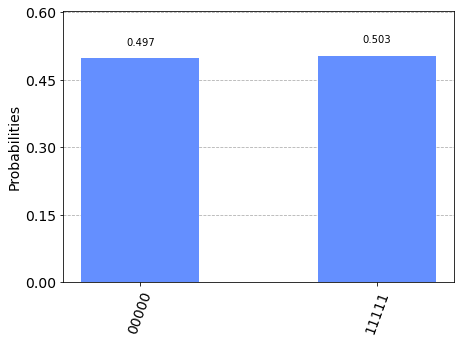

In [152]:
from qiskit.tools.visualization import plot_histogram

# 4) Lets get the results of the executed circuit
counts = results.get_counts()
plot_histogram(counts)

Here we simply created a circuit, transpiled the circuit, executed the circuit on a backend, and printed the results. 
However, before that circuit can execute on a (simulated or real) backend, we must transpile it as shown in step 2.
In the rest of this tutorial we will focus on the transpilation process and what goes on behind the scenes of step 2. 

# Transpilation Process

The goal of the transpilation process is to injest a quantum circuit and spit out an optimized quantum circuit. 




              ---------------------------> Insert transpilation process picture here <---------------------------
Note: For more information about the transpilation process please visit:
https://qiskit.org/documentation/apidoc/transpiler.html

###  Back to our example
This is exactly what we did in step 2 earlier,
```{python}
simulated_backend = Aer.get_backend('aer_simulator')
transpiled_qc = transpile(qc, simulated_backend)
```
The transpile function uses the ``backend`` parameter to optimize the quantum circuit according to the particular hardware the quantum circuit will be running on, therefore, the transpilation process is **"hardware aware"**. 

### What other parameters does the `transpile()` function use?
The `transpile()` function has another parameter called `optimization_level`, which uses a predefined transpilation process. As shown earlier, the transpilation process involves gate optimization, device connectivity optimization and more, but again Qiskit abstracts these concepts and allows you to use one of four predefined transpilation processes. By default `optimization_level=1`, but we can set it four different values as shown here:
```{python}
simulated_backend = Aer.get_backend('aer_simulator')
transpiled_qc0 = transpile(qc, simulated_backend, optimization_level=0)  # No Optimization
transpiled_qc1 = transpile(qc, simulated_backend, optimization_level=1)  # Some Optimization
transpiled_qc2 = transpile(qc, simulated_backend, optimization_level=2)  # More Optimization
transpiled_qc3 = transpile(qc, simulated_backend, optimization_level=3)  # Maximum Optimization
```

Note: For more information about the traspiler parameters please visit:
https://qiskit.org/documentation/stubs/qiskit.compiler.transpile.html

# Bernstein-Vazirani Circuit for 3 bit hidden string s

In [145]:
### Lets defined a new circuit of your choice with no measurements

n = 3 # number of qubits used to represent s
s = '011'   # the hidden binary string


# We need a circuit with n qubits, plus one auxiliary qubit
# Also need n classical bits to write the output to
qc = QuantumCircuit(n+1, n)

# put auxiliary in state |->
qc.h(n)
qc.z(n)

# Apply Hadamard gates before querying the oracle
for i in range(n):
    qc.h(i)
    
# Apply barrier 
qc.barrier()

# Apply the inner-product oracle
s = s[::-1] # reverse s to fit qiskit's qubit ordering
for q in range(n):
    if s[q] == '0':
        qc.i(q)
    else:
        qc.cx(q, n)
        
# Apply barrier 
qc.barrier()

#Apply Hadamard gates after querying the oracle
for i in range(n):
    qc.h(i)

'''    
# Measurement
for i in range(n):
    qc.measure(i, i)
'''
qc.draw()

┌───┐      ░                 ░ ┌───┐
q_0: ┤ H ├──────░───■─────────────░─┤ H ├
     ├───┤      ░   │             ░ ├───┤
q_1: ┤ H ├──────░───┼─────────■───░─┤ H ├
     ├───┤      ░   │  ┌───┐  │   ░ ├───┤
q_2: ┤ H ├──────░───┼──┤ I ├──┼───░─┤ H ├
     ├───┤┌───┐ ░ ┌─┴─┐└───┘┌─┴─┐ ░ └───┘
q_3: ┤ H ├┤ Z ├─░─┤ X ├─────┤ X ├─░──────
     └───┘└───┘ ░ └───┘     └───┘ ░      
c: 3/════════════════════════════════════

### Optimization_level=0
This option does no optimization, so you end up using your input circuit on your hardware. This will give bad results because your circuit does not consider the device connectivity, there is no reduction of swap gates, etc.

In [153]:
# Define a simulated noisy backend
simulated_backend = FakeBoeblingen()

transpiled_qc0 = transpile(qc, simulated_backend, optimization_level=0)  # No Optimization
print('Optimization Level 0')
print('Depth:', transpiled_qc0.depth())
print('Gate counts:', transpiled_qc0.count_ops())
transpiled_qc0.draw()

Optimization Level 0
Depth: 15
Gate counts: OrderedDict([('cx', 16), ('measure', 5), ('u2', 1), ('barrier', 1)])


┌─────────┐          ┌───┐                                   »
        q_0 -> 0 ┤ U2(0,π) ├──■────■──┤ X ├──■────────────────────────────────»
                 └─────────┘┌─┴─┐┌─┴─┐└─┬─┘┌─┴─┐                              »
        q_1 -> 1 ───────────┤ X ├┤ X ├──■──┤ X ├──■───────────────────■────■──»
                            └───┘└───┘     └───┘┌─┴─┐     ┌───┐     ┌─┴─┐┌─┴─┐»
        q_2 -> 2 ───────────────────────────────┤ X ├──■──┤ X ├──■──┤ X ├┤ X ├»
                                                └───┘┌─┴─┐└─┬─┘┌─┴─┐└───┘├───┤»
        q_3 -> 3 ────────────────────────────────────┤ X ├──■──┤ X ├──■──┤ X ├»
                                                     └───┘     └───┘┌─┴─┐└─┬─┘»
        q_4 -> 4 ───────────────────────────────────────────────────┤ X ├──■──»
                                                                    └───┘     »
  ancilla_0 -> 5 ─────────────────────────────────────────────────────────────»
                                                                              »
  ancilla_1 -> 6 ─────────────────────────────────────────────────────────────»
                                                                              »
  ancilla_2 -> 7 ─────────────────────────────────────────────────────────────»
                                                                              »
  ancilla_3 -> 8 ─────────────────────────────────────────────────────────────»
                                                                              »
  ancilla_4 -> 9 ─────────────────────────────────────────────────────────────»
                                                                              »
 ancilla_5 -> 10 ─────────────────────────────────────────────────────────────»
                                                                              »
 ancilla_6 -> 11 ─────────────────────────────────────────────────────────────»
                                                                              »
 ancilla_7 -> 12 ─────────────────────────────────────────────────────────────»
                                                                              »
 ancilla_8 -> 13 ─────────────────────────────────────────────────────────────»
                                                                              »
 ancilla_9 -> 14 ─────────────────────────────────────────────────────────────»
                                                                              »
ancilla_10 -> 15 ─────────────────────────────────────────────────────────────»
                                                                              »
ancilla_11 -> 16 ─────────────────────────────────────────────────────────────»
                                                                              »
ancilla_12 -> 17 ─────────────────────────────────────────────────────────────»
                                                                              »
ancilla_13 -> 18 ─────────────────────────────────────────────────────────────»
                                                                              »
ancilla_14 -> 19 ─────────────────────────────────────────────────────────────»
                                                                              »
         meas: 5/═════════════════════════════════════════════════════════════»
                                                                              »
«                                 ░    ┌─┐         
«        q_0 -> 0 ────────────────░────┤M├─────────
«                 ┌───┐           ░    └╥┘   ┌─┐   
«        q_1 -> 1 ┤ X ├──■────────░─────╫────┤M├───
«                 └─┬─┘┌─┴─┐      ░ ┌─┐ ║    └╥┘   
«        q_2 -> 2 ──■──┤ X ├──■───░─┤M├─╫─────╫────
«                      └───┘┌─┴─┐ ░ └╥┘ ║     ║ ┌─┐
«        q_3 -> 3 ──■───────┤ X ├─░──╫──╫─────╫─┤M├
«                 ┌─┴─┐     └───┘ ░  ║  ║ ┌─┐ ║ └╥┘
«        q_4 -> 4 ┤ X ├───────────░──╫──╫─┤M├─╫──╫─
«                 └───┘           ░  ║  ║ └╥┘ ║  ║ 
«  an

### Optimization_level=1


In [154]:
# Define a simulated noisy backend
simulated_backend = FakeBoeblingen()

transpiled_qc1 = transpile(qc, simulated_backend, optimization_level=1)  # No Optimization
print('Optimization Level 1')
print('Depth:', transpiled_qc1.depth())
print('Gate counts:', transpiled_qc1.count_ops())
transpiled_qc1.draw()

Optimization Level 1
Depth: 15
Gate counts: OrderedDict([('cx', 16), ('measure', 5), ('u2', 1), ('barrier', 1)])


»
        q_4 -> 0 ─────────────────────────────────────────────────────────────»
                                      ┌───┐                    ┌───┐     ┌───┐»
        q_3 -> 1 ─────────────■───────┤ X ├───────■────────────┤ X ├──■──┤ X ├»
                              │  ┌───┐└─┬─┘       │  ┌───┐     └─┬─┘  │  └─┬─┘»
        q_1 -> 2 ─────────────┼──┤ X ├──┼────■────┼──┤ X ├──■────■────┼────┼──»
                 ┌─────────┐  │  └─┬─┘  │  ┌─┴─┐  │  └─┬─┘┌─┴─┐       │    │  »
        q_0 -> 3 ┤ U2(0,π) ├──┼────■────┼──┤ X ├──┼────■──┤ X ├───────┼────┼──»
                 └─────────┘  │         │  └───┘  │       └───┘       │    │  »
  ancilla_0 -> 4 ─────────────┼─────────┼─────────┼───────────────────┼────┼──»
                              │         │         │                   │    │  »
  ancilla_1 -> 5 ─────────────┼─────────┼─────────┼───────────────────┼────┼──»
                            ┌─┴─┐       │       ┌─┴─┐               ┌─┴─┐  │  »
        q_2 -> 6 ───────────┤ X ├───────■───────┤ X ├───────────────┤ X ├──■──»
                            └───┘               └───┘               └───┘     »
  ancilla_2 -> 7 ─────────────────────────────────────────────────────────────»
                                                                              »
  ancilla_3 -> 8 ─────────────────────────────────────────────────────────────»
                                                                              »
  ancilla_4 -> 9 ─────────────────────────────────────────────────────────────»
                                                                              »
 ancilla_5 -> 10 ─────────────────────────────────────────────────────────────»
                                                                              »
 ancilla_6 -> 11 ─────────────────────────────────────────────────────────────»
                                                                              »
 ancilla_7 -> 12 ─────────────────────────────────────────────────────────────»
                                                                              »
 ancilla_8 -> 13 ─────────────────────────────────────────────────────────────»
                                                                              »
 ancilla_9 -> 14 ─────────────────────────────────────────────────────────────»
                                                                              »
ancilla_10 -> 15 ─────────────────────────────────────────────────────────────»
                                                                              »
ancilla_11 -> 16 ─────────────────────────────────────────────────────────────»
                                                                              »
ancilla_12 -> 17 ─────────────────────────────────────────────────────────────»
                                                                              »
ancilla_13 -> 18 ─────────────────────────────────────────────────────────────»
                                                                              »
ancilla_14 -> 19 ─────────────────────────────────────────────────────────────»
                                                                              »
         meas: 5/═════════════════════════════════════════════════════════════»
                                                                              »
«                                          ┌───┐ ░             ┌─┐
«        q_4 -> 0 ─────────────────────────┤ X ├─░─────────────┤M├
«                      ┌───┐     ┌───┐     └─┬─┘ ░ ┌─┐         └╥┘
«        q_3 -> 1 ──■──┤ X ├──■──┤ X ├──■────■───░─┤M├──────────╫─
«                   │  └─┬─┘┌─┴─┐└─┬─┘┌─┴─┐      ░ └╥┘      ┌─┐ ║ 
«        q_1 -> 2 ──┼────■──┤ X ├──■──┤ X ├──────░──╫───────┤M├─╫─
«                   │       └───┘     └───┘      ░  ║ ┌─┐   └╥┘ ║ 
«        q_0 -> 3 ──┼────────────────────────────░──╫─┤M├────╫──╫─
«                   │                            ░  ║ └╥┘    ║  ║ 
«  ancilla_0 -> 4 ──┼──────────────

### Optimization_level=2


In [155]:
# Define a simulated noisy backend
simulated_backend = FakeBoeblingen()

transpiled_qc2 = transpile(qc, simulated_backend, optimization_level=2)  # No Optimization
print('Optimization Level 2')
print('Depth:', transpiled_qc2.depth())
print('Gate counts:', transpiled_qc2.count_ops())
transpiled_qc2.draw()

Optimization Level 2
Depth: 15
Gate counts: OrderedDict([('cx', 22), ('measure', 5), ('u2', 1), ('barrier', 1)])


┌───┐»
        q_4 -> 0 ─────────────────────────────────────────────────────■──┤ X ├»
                                                     ┌───┐          ┌─┴─┐└─┬─┘»
        q_3 -> 1 ────────────────────────────■───────┤ X ├───────■──┤ X ├──■──»
                            ┌───┐            │       └─┬─┘       │  └───┘     »
        q_1 -> 2 ───────────┤ X ├────────────┼─────────┼─────────┼────────────»
                 ┌─────────┐└─┬─┘            │  ┌───┐  │         │            »
        q_0 -> 3 ┤ U2(0,π) ├──■─────────■────┼──┤ X ├──┼────■────┼────────────»
                 └─────────┘            │    │  └─┬─┘  │    │    │            »
  ancilla_0 -> 4 ───────────────────────┼────┼────┼────┼────┼────┼────────────»
                                        │    │    │    │    │    │            »
  ancilla_1 -> 5 ───────────────────────┼────┼────┼────┼────┼────┼────────────»
                            ┌───┐       │  ┌─┴─┐  │    │    │  ┌─┴─┐          »
        q_2 -> 6 ─────■─────┤ X ├──■────┼──┤ X ├──┼────■────┼──┤ X ├──────────»
                    ┌─┴─┐   └─┬─┘┌─┴─┐  │  └───┘  │         │  ├───┤     ┌───┐»
  ancilla_2 -> 7 ───┤ X ├─────■──┤ X ├──┼─────────┼─────────┼──┤ X ├──■──┤ X ├»
                    └───┘        └───┘┌─┴─┐       │       ┌─┴─┐└─┬─┘┌─┴─┐└─┬─┘»
  ancilla_3 -> 8 ─────────────────────┤ X ├───────■───────┤ X ├──■──┤ X ├──■──»
                                      └───┘               └───┘     └───┘     »
  ancilla_4 -> 9 ─────────────────────────────────────────────────────────────»
                                                                              »
 ancilla_5 -> 10 ─────────────────────────────────────────────────────────────»
                                                                              »
 ancilla_6 -> 11 ─────────────────────────────────────────────────────────────»
                                                                              »
 ancilla_7 -> 12 ─────────────────────────────────────────────────────────────»
                                                                              »
 ancilla_8 -> 13 ─────────────────────────────────────────────────────────────»
                                                                              »
 ancilla_9 -> 14 ─────────────────────────────────────────────────────────────»
                                                                              »
ancilla_10 -> 15 ─────────────────────────────────────────────────────────────»
                                                                              »
ancilla_11 -> 16 ─────────────────────────────────────────────────────────────»
                                                                              »
ancilla_12 -> 17 ─────────────────────────────────────────────────────────────»
                                                                              »
ancilla_13 -> 18 ─────────────────────────────────────────────────────────────»
                                                                              »
ancilla_14 -> 19 ─────────────────────────────────────────────────────────────»
                                                                              »
         meas: 5/═════════════════════════════════════════════════════════════»
                                                                              »
«                                                ░                
«        q_4 -> 0 ──■────────────────────────────░────────────────
«                 ┌─┴─┐                    ┌───┐ ░             ┌─┐
«        q_3 -> 1 ┤ X ├────────────────────┤ X ├─░─────────────┤M├
«                 └───┘                    └─┬─┘ ░    ┌─┐      └╥┘
«        q_1 -> 2 ───────────────────────────┼───░────┤M├───────╫─
«                                            │   ░    └╥┘       ║ 
«        q_0 -> 3 ───────────────────────────┼───░─────╫────────╫─
«                                            │   ░     ║        ║ 
«  ancilla_0 -> 4 ────────────

### Optimization_level=3


In [156]:
# Define a simulated noisy backend
simulated_backend = FakeBoeblingen()

transpiled_qc3 = transpile(qc, simulated_backend, optimization_level=3)  # No Optimization
print('Optimization Level 3')
print('Depth:', transpiled_qc3.depth())
print('Gate counts:', transpiled_qc3.count_ops())
transpiled_qc3.draw()

Optimization Level 3
Depth: 7
Gate counts: OrderedDict([('cx', 5), ('measure', 5), ('u2', 1), ('barrier', 1)])


░                
  ancilla_0 -> 0 ─────────────────────────────────────░────────────────
                                                      ░                
  ancilla_1 -> 1 ─────────────────────────────────────░────────────────
                                                      ░                
  ancilla_2 -> 2 ─────────────────────────────────────░────────────────
                                                      ░                
  ancilla_3 -> 3 ─────────────────────────────────────░────────────────
                                                      ░                
  ancilla_4 -> 4 ─────────────────────────────────────░────────────────
                                                      ░                
  ancilla_5 -> 5 ─────────────────────────────────────░────────────────
                                                      ░                
  ancilla_6 -> 6 ─────────────────────────────────────░────────────────
                                                      ░                
  ancilla_7 -> 7 ─────────────────────────────────────░────────────────
                                                      ░                
  ancilla_8 -> 8 ─────────────────────────────────────░────────────────
                                                      ░                
  ancilla_9 -> 9 ─────────────────────────────────────░────────────────
                                                      ░                
ancilla_10 -> 10 ─────────────────────────────────────░────────────────
                                                      ░                
ancilla_11 -> 11 ─────────────────────────────────────░────────────────
                            ┌───┐                     ░       ┌─┐      
       q_2 -> 12 ───────────┤ X ├─────────────────────░───────┤M├──────
                 ┌─────────┐└─┬─┘     ┌───┐           ░    ┌─┐└╥┘      
       q_0 -> 13 ┤ U2(0,π) ├──■────■──┤ X ├──■────────░────┤M├─╫───────
                 └─────────┘     ┌─┴─┐└─┬─┘  │        ░    └╥┘ ║ ┌─┐   
       q_3 -> 14 ────────────────┤ X ├──┼────┼────────░─────╫──╫─┤M├───
                                 └───┘  │    │        ░     ║  ║ └╥┘   
ancilla_12 -> 15 ───────────────────────┼────┼────────░─────╫──╫──╫────
                                        │    │        ░     ║  ║  ║    
ancilla_13 -> 16 ───────────────────────┼────┼────────░─────╫──╫──╫────
                                        │    │        ░     ║  ║  ║    
ancilla_14 -> 17 ───────────────────────┼────┼────────░─────╫──╫──╫────
                                        │  ┌─┴─┐      ░ ┌─┐ ║  ║  ║    
       q_1 -> 18 ───────────────────────■──┤ X ├──■───░─┤M├─╫──╫──╫────
                                           └───┘┌─┴─┐ ░ └╥┘ ║  ║  ║ ┌─┐
       q_4 -> 19 ───────────────────────────────┤ X ├─░──╫──╫──╫──╫─┤M├
                                                └───┘ ░  ║  ║  ║  ║ └╥┘
         meas: 5/════════════════════════════════════════╩══╩══╩══╩══╩═
                                                         0  1  2  3  4

# Extra Miscellaneous

Qiskit allows the user to create a Quantum Circuit with any quantum gate(unitary operation) they want. However,  


Before we begin with Gate Optimization of a Quantum Circuit in Qiskit, we must establish a few things first:
1. 
2. 


This is very important because an optimized circuit for, say, a 5 qubit quantum processor, will not be optimized for another quantum processor. Differences between quantum processors are:
1. Device Connectivity
2. etc.



import numpy as np
from qiskit import Aer, transpile
from qiskit.tools.visualization import plot_histogram, plot_state_city
import qiskit.quantum_info as qi

# Transpile for simulator
simulator = Aer.get_backend('aer_simulator')
circ = transpile(qc, simulator)

'''
for i in circ:
    print(i)
dag = circuit_to_dag(circ)
dag_drawer(circ)
'''



# Run and get counts
print("    Transpile: ", circ)
print("Simulator Run: ", simulator.run(circ))

'''
result = simulator.run(circ).result()
counts = result.get_counts(circ)
plot_histogram(counts, title='Bell-State counts')
'''